In [20]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [21]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [22]:
def plot_imgs(input_imgs):
    plt.figure(figsize=(10,10))
    plt_idx = 1
    for i in range(36):
        plt.subplot(6,6,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.squeeze(input_imgs[i]), cmap="gray", vmin=0, vmax=1)
    plt.show()

In [23]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

In [24]:
cat_idx = 3
dog_idx = 5

x_cat_train = x_train[np.where(y_train==cat_idx)]
x_cat_test = x_test[np.where(y_test==cat_idx)]

x_dog_train = x_train[np.where(y_train==dog_idx)]
x_dog_test = x_test[np.where(y_test==dog_idx)]

x_train = np.concatenate((x_cat_train, x_dog_train))
x_test = np.concatenate((x_cat_test, x_dog_test))

# 猫が0,犬が1
y_train = np.concatenate((np.zeros(x_cat_train.shape[0]),np.ones(x_dog_train.shape[0])))
y_test = np.concatenate((np.zeros(x_cat_test.shape[0]),np.ones(x_dog_test.shape[0])))



In [25]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train,test_size=0.33, random_state=42)

In [26]:
# Preprocess the data
x_train = x_train.astype('float32') / 255
x_valid = x_valid.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Apply data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(x_train)

# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Apply early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Fit the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=16),
                    epochs=100,
                    validation_data=(x_valid, y_valid),
                    callbacks=[es])

# Test the model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/100
419/419 [==============================] - 10s 11ms/step - loss: 0.8140 - accuracy: 0.5657 - val_loss: 0.6549 - val_accuracy: 0.6103
Epoch 2/100
419/419 [==============================] - 4s 10ms/step - loss: 0.6970 - accuracy: 0.6016 - val_loss: 0.6052 - val_accuracy: 0.6679
Epoch 3/100
419/419 [==============================] - 4s 10ms/step - loss: 0.6413 - accuracy: 0.6400 - val_loss: 0.5695 - val_accuracy: 0.7115
Epoch 4/100
419/419 [==============================] - 4s 10ms/step - loss: 0.5995 - accuracy: 0.6748 - val_loss: 0.5759 - val_accuracy: 0.7052
Epoch 5/100
419/419 [==============================] - 4s 10ms/step - loss: 0.5746 - accuracy: 0.6972 - val_loss: 0.5581 - val_accuracy: 0.7188
Epoch 6/100
419/419 [==============================] - 4s 10ms/step - loss: 0.5510 - accuracy: 0.7076 - val_loss: 0.5184 - val_accuracy: 0.7291
Epoch 7/100
419/419 [==============================] - 4s 10ms/step - loss: 0.5385 - accuracy: 0.7297 - val_loss: 0.5564 - val_accuracy

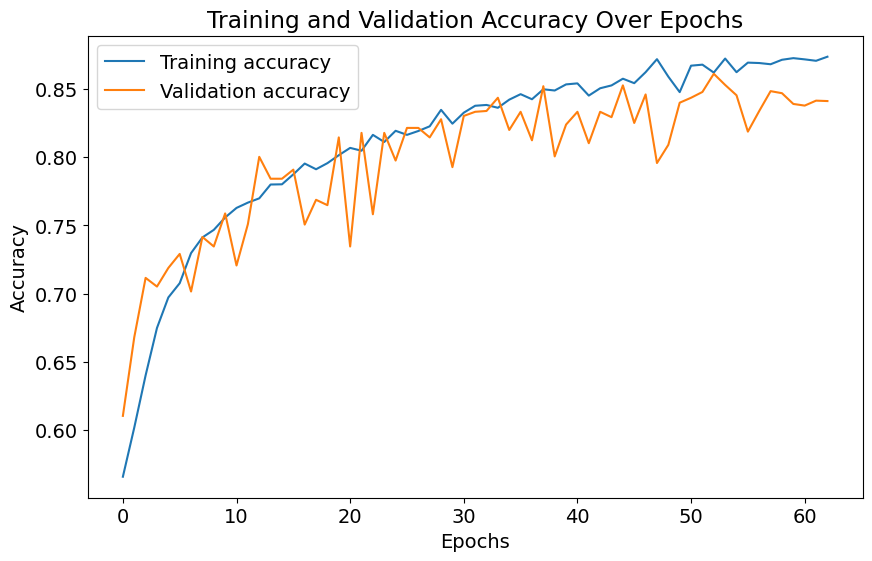

In [30]:
history = history.history
# フォントサイズを設定
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(10, 6))

# 精度のプロット
plt.plot(np.arange(len(history["accuracy"])), history["accuracy"], label="Training accuracy")
plt.plot(np.arange(len(history["val_accuracy"])), history["val_accuracy"], label="Validation accuracy")

# タイトルと軸ラベルを追加
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# 凡例を追加
plt.legend()

# グラフを表示
plt.show()


63/63 [==============================] - 0s 2ms/step


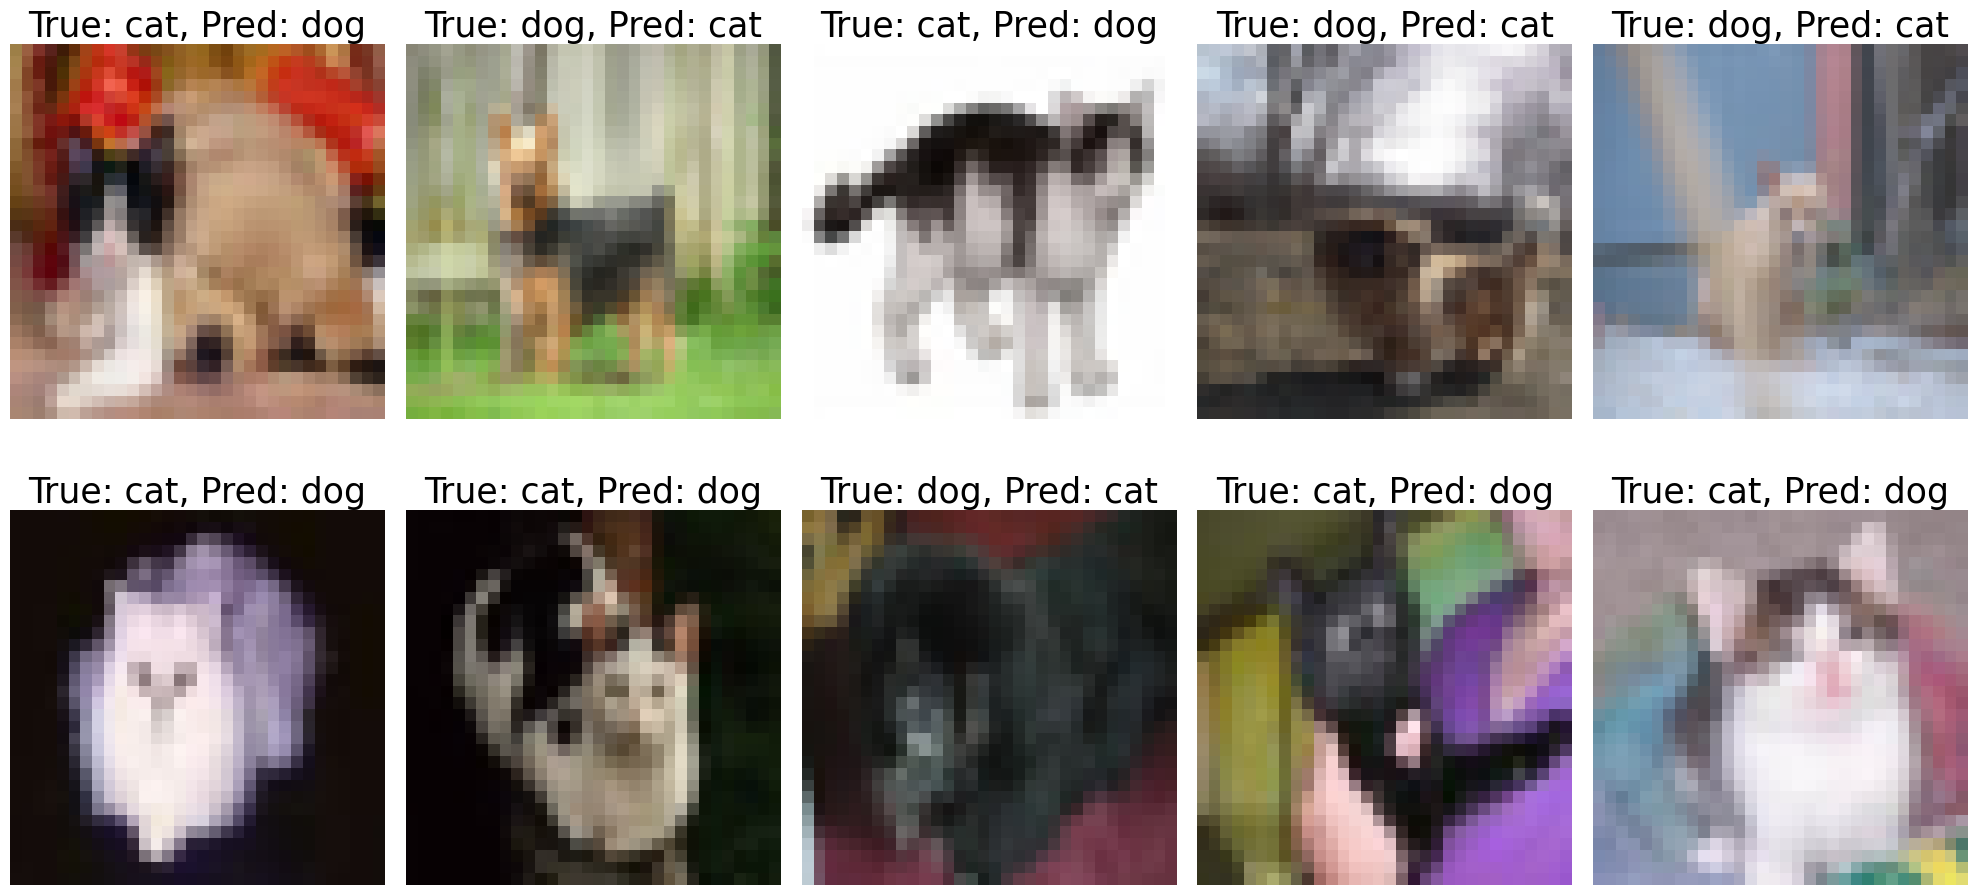

In [32]:
# Get the model's predictions
y_pred = model.predict(x_test)
y_pred_classes = np.round(y_pred).flatten()

# Find the indices where the model's prediction does not match the true label
wrong_indices = np.where(y_test != y_pred_classes)[0]

# Select some random images among the misclassified ones
num_samples = 10  # specify the number of samples you want to display
random_indices = np.random.choice(wrong_indices, num_samples)

# Create a dictionary to map the labels
label_dict = {0: 'cat', 1: 'dog'}

# Create a figure with larger size
plt.figure(figsize=(20, 10))

# Plot the selected samples
for i, idx in enumerate(random_indices):
    plt.subplot(2, num_samples//2, i+1)
    plt.imshow(x_test[idx], cmap='gray', vmin=0, vmax=1)
    plt.title(f"True: {label_dict[y_test[idx]]}, Pred: {label_dict[y_pred_classes[idx]]}", fontsize=25) # use smaller font size
    plt.axis('off')

plt.tight_layout()  # Adjust the layout
plt.show()
